<a href="https://colab.research.google.com/github//asabenhur/CS425/blob/master/notebooks/03_dot_plots.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Dot plots as a tool for visualizing sequence similarity

The objective of this notebook is for you to familiarize yourself with *dot plots* and how they can be used to understand the relationship between sequences.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

In [5]:
"""
A parser for FASTA files.

It can handle files that are local or on the web.
Gzipped files do not need to be unzipped.
"""

import os
from urllib.request import urlopen

def myopen(fileName) :

    if not ( os.path.exists(fileName) and os.path.isfile(fileName) ):
        raise ValueError('file does not exist at %s' % fileName)
    
    import gzip
    fileHandle = gzip.GzipFile(fileName)

    gzippedFile = True
    try :
        line = fileHandle.readline()
        fileHandle.close()
    except :
        gzippedFile = False

    if gzippedFile :
        return gzip.GzipFile(fileName)
    else :
        return open(fileName)


class MalformedInput :
    "Exception raised when the input file does not look like a fasta file."
    pass

class FastaRecord :
    """Represents a record in a fasta file."""
    def __init__(self, header, sequence):
        """Create a record with the given header and sequence."""
        self.header = header
        self.sequence = sequence
    def __str__(self) :
        return '>' + self.header + '\n' + self.sequence + '\n'

    
def _fasta_itr_from_file(file_handle) :
    "Provide an iteration through the fasta records in file."

    h = file_handle.readline()[:-1]
    if h[0] != '>':
        raise MalformedInput()
    h = h[1:]

    seq = []
    for line in file_handle:
        line = line[:-1] # remove newline
        if line[0] == '>':
            yield FastaRecord(h,''.join(seq))
            h = line[1:]
            seq = []
            continue
        seq.append(line)

    yield FastaRecord(h,''.join(seq))

        
def _fasta_itr_from_web(file_handle) :
    "Iterate through a fasta file posted on the web."

    h = file_handle.readline().decode("utf-8")[:-1]
    if h[0] != '>':
        raise MalformedInput()
    h = h[1:]

    seq = []
    for line in file_handle:
        line = line.decode("utf-8")[:-1] # remove newline
        if line[0] == '>':
            yield FastaRecord(h,''.join(seq))
            h = line[1:]
            seq = []
            continue
        seq.append(line)

    yield FastaRecord(h,''.join(seq))



def _fasta_itr_from_name(fname):
    "Iterate through a fasta file with the given name."

    f = myopen(fname)
    for rec in _fasta_itr_from_file(f) :
        yield rec


def _fasta_itr(src):
    """Provide an iteration through the fasta records in file `src'.
    
    Here `src' can be either a file name or a url of a file.
    """
    if type(src) == str :
        if src.find("http")>=0 :
            file_handle = urlopen(src)
            return _fasta_itr_from_web(file_handle)
        else :
            return _fasta_itr_from_name(src)
    else:
        raise TypeError

    
class fasta_itr (object) :
    """An iterator through a Fasta file"""

    def __init__(self, src) :
        """Create an iterator through the records in src."""
        self.__itr = _fasta_itr(src)

    def __iter__(self) :
        return self

    def __next__(self) :
        return self.__itr.__next__()

### Dot plots

<img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/3/33/Zinc-finger-dot-plot.png" width="200">

A *dot plot* is a useful visualization technique for comparing a pair of sequences, $u$ and $v$.  In its simplest form, a dot plot is a scatterplot in which there is a point at coordinate $(i,j)$ if $u_i = v_j$.  Write a function below that returns a matrix of zeros and ones $A$ such that $A_{ij} = 1$ if $v_i = v_j$ and zero otherwise.


### Exercise:  Generating the matrix for a dot plot

Write the code for the function shown below that computes the matrix for a dot plot.


In [2]:
def dot_plot_matrix(seq1, seq2):
    """
    Computes the matrix for a dot plot of two sequences
    Args:
        seq1: the first string
        seq2: the second string
    Returns:
        A matrix A such that A_ij = 1 if seq1[i] == seq2[j]
        and zero otherwise
    """
    A = np.zeros((len(seq1), len(seq2)))
    
    return A

In [3]:
dot_plot_matrix("ACGT", "ACGT")

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [4]:
dot_plot_matrix("ACGT", "TGCA")

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

### Plotting a dot plot of alpha vs. delta globin proteins

Included with this notebook is a FASTA-formatted file containing the amino acid sequences of human alpha and delta globin, which are related genes.  Next, we will create a dotplot of the amino acids sequences of these two genes.  To visualize the matrix use  matplotlib as shown here:

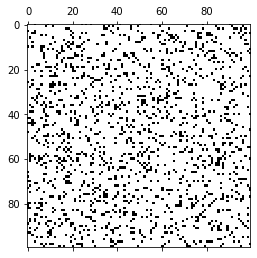

In [14]:
from numpy.random import default_rng
rng = default_rng()
A = rng.choice([0, 1], p=[0.85, 0.15], size=(100,100))

plt.matshow(A, cmap='gray_r');


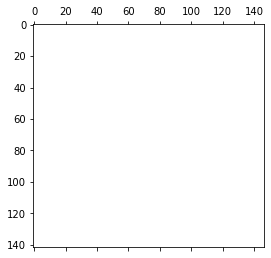

In [17]:
# read the globin sequences
fasta_iterator = fasta_itr(
    "https://raw.githubusercontent.com/asabenhur/CS425/main/data/human_alpha_and_delta_globin.fasta")
seq1,seq2 = [record.sequence for record in fasta_iterator]

# compute the dot plot matrix
A = dot_plot_matrix(seq1, seq2)

plt.matshow(A, cmap='gray_r');

What do you notice in this dot plot?  Do these two genes appear to be related?

*ENTER YOUR OBSERVATIONS HERE*

### Exercise: Generating dot plots using k-mer matches

As a variation, we can generalize the approach to compute points at which there are identical length $k$ substrings in the two strings.  Setting $k > 1$ may allow us to filter out many of the spurious points in the plot you have created above.

In [15]:
def dot_plot_kmer(seq1, seq2, k):
    """Computes the matrix for a dot plot that looks for 
    matching k-mers

    Args:
        seq1: the first string
        seq2: the second string
        k: the length of the substrings to compare
    Returns:
        A matrix A such that A_{ij} is nonzero iff there 
        is a length k kmer at position i in seq1 that is an
        exact match to a kmer at position j in seq2
    """
    pass

In [16]:
dot_plot_kmer("ATCGTAGC", "ACGTAGCGG", 3)

### A k-mer dot plot of the alpha and delta globin sequences

Now we will create a dotplot of the amino acids sequences of the two globin genes, with k-mer derived points, starting with $k = 2$.

In [ ]:
# code showing k-mer dot plots for the two globin sequences

What do you notice in this dot plot compared to the plot from the first exercise?  What happens as you increase the value of $k$?

*YOUR OBSERVATIONS HERE*